<a href="https://colab.research.google.com/github/luisArthurRodriguesDaSilva/estudo-dados-eleicoes/blob/master/mapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
import folium
import requests
import pandas as pd
import numpy as np
import json
import pickle as pike
from zipfile import ZipFile

In [119]:
zipado = requests.get('https://cdn.tse.jus.br/estatistica/sead/eleicoes/eleicoes2022/buweb/bweb_2t_RR_311020221535.zip')
open('zipe.zip','wb').write(zipado.content)

file_name = "zipe.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
bweb_2t_RR_311020221535.csv                    2022-10-31 18:51:20      2131143
leiame-boletimurnaweb.pdf                      2020-11-18 23:13:06       337455
Extracting all the files now...
Done!


In [ ]:
brasil_ufs = ['ac','al','am','ap','ba','ce','df','es','go','ma','mt','ms','mg','pa','pb','pr','pe','pi','rj','rn','ro','rs','rr','sc','se','sp','to']
BRASIL_UFS =  list(map(lambda x: x.upper(),brasil_ufs))

In [ ]:
path = '/content/drive/MyDrive/electionsData.pkl'
with open(path,'rb') as f:
  electionsData = (pike.load(f))

In [ ]:
def getScore(uf,candidato):
  info = electionsData[uf]['Presidente']
  candidateData = info[(info['Nome do Candidato']==candidato)]
  return (candidateData['(%) Votos'].values[0])
getScore('rj','JAIR BOLSONARO')

51.09

In [ ]:
electionsData['rj']['Presidente']

In [ ]:
url = 'https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/brazil-states.geojson'
data = requests.get(url).json()

In [ ]:
def generateMap(df,color,candidate):
  mapa = folium.Map(location=[-10, -30], zoom_start=4)

  mapa.choropleth(geo_data=data, data=df,
                  columns=['state','% Votos'],
                  key_on='properties.sigla',  # Check your GeoJSON for the name!
                  fill_color=color,
                  fill_opacity=0.7, 
                  line_opacity=0.2,legend_name=f'% de Votos para {candidate}')

  return mapa

In [ ]:
candColors = {
    'bolsoColor': 'PuBuGn',
    'lulaColor':'OrRd',
    'ciroColor':'PuBuGn'
}

def showCandidateMap(candidate, color):
  votes = list(map(lambda uf:float(getScore(uf,candidate)),brasil_ufs))
  usedDf = pd.DataFrame(np.c_[BRASIL_UFS, votes], columns=['state', '% Votos'])

  usedDf['% Votos'] = pd.Series(votes, dtype=float)
  return generateMap(usedDf,color,candidate)
showCandidateMap('JAIR BOLSONARO',candColors['bolsoColor'])

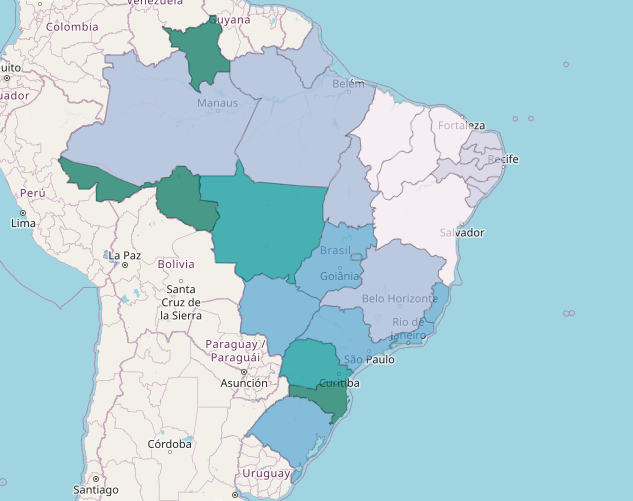

In [ ]:
showCandidateMap('LULA',candColors['lulaColor'])

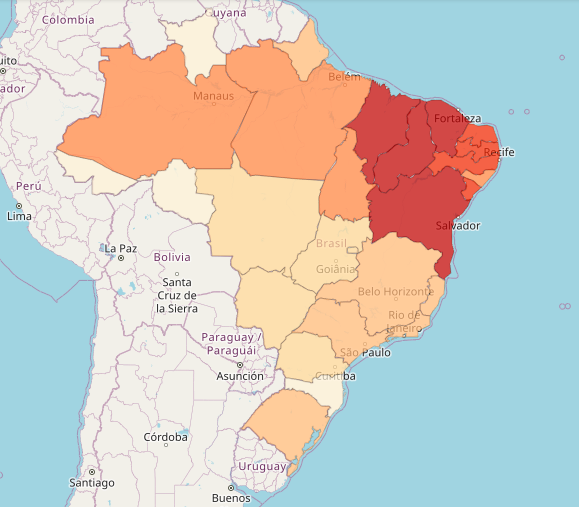

In [ ]:
municipiosRR = pd.read_html('http://www.fazenda.mg.gov.br/governo/assuntos_municipais/codigomunicipio/codmunicoutest_rr.html',match='Município' )[0][0][3:18].values[0:]
municipiosRR = ['ALTO ALEGRE', 'AMAJARI', 'BOA VISTA', 'BONFIM', 'CANTÁ',
       'CARACARAÍ', 'CAROEBE', 'IRACEMA', 'MUCAJAÍ', 'NORMANDIA',
       'PACARAIMA', 'RORAINÓPOLIS', 'SÃO JOÃO DA BALIZA', 'SÃO LUIZ',
       'UIRAMUTÃ']

In [ ]:
pathRR = '/content/drive/MyDrive/dados eleições/bweb_2t_RR_311020221535.csv'

with open(pathRR , 'rb') as f :
  munRRdata = pd.read_csv(f,sep=";",encoding='latin-1')

simpleData = munRRdata.drop(columns=
                        ['ANO_ELEICAO',
                         'DT_GERACAO',
                         'HH_GERACAO',
                         'CD_TIPO_ELEICAO',
                         'NM_TIPO_ELEICAO',
                         'NR_TURNO',
                         'CD_ELEICAO',
                         ])


simpRRdata = simpleData.groupby(by= ['NM_MUNICIPIO','NR_PARTIDO']).agg(
    quantidade = ('QT_VOTOS','sum')
)

simpRRdata['quantidade']

In [ ]:
simpRRdata.head()

In [ ]:
geoRRjson = requests.get('https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-14-mun.json').json()
for index, mun in enumerate(geoRRjson['features']) :
  geoRRjson['features'][index]['properties']['name'] = mun['properties']['name'].capitalize()

In [ ]:
def getPorcentagemRR(mun,num):
  bolso = simpRRdata['quantidade'][mun][22]
  lula = simpRRdata['quantidade'][mun][13]
  totalValid = bolso + lula
  return simpRRdata['quantidade'][mun][num] / totalValid

In [ ]:
# def generateMap(df,color,candidate):
#   mapa = folium.Map(location=[-10, -30], zoom_start=4)

#   mapa.choropleth(geo_data=data, data=df,
#                   columns=['state','% Votos'],
#                   key_on='properties.sigla',  # Check your GeoJSON for the name!
#                   fill_color=color,
#                   fill_opacity=0.7, 
#                   line_opacity=0.2,legend_name=f'% de Votos para {candidate}')

votes = list(map(lambda mun:float(getPorcentagemRR(mun,22)*100),municipiosRR))
muns = list(map(lambda mun:mun.capitalize(),municipiosRR))
usedDf = pd.DataFrame(np.c_[muns, votes], columns=['state', '% Votos'])

usedDf['% Votos'] = pd.Series(votes, dtype=float)

mapa = folium.Map(location=[2, -60], zoom_start=7)

mapa.choropleth(geo_data=geoRRjson, data=usedDf,
                  columns=['state','% Votos'],
                  key_on='properties.name',  # Check your GeoJSON for the name!
                  fill_color='YlGn',
                  fill_opacity=1, 
                  line_opacity=1,legend_name=f'% de Votos para bolsonario')
mapa

In [ ]:
usedDf

Mapa de roraima e o bolsonarismo

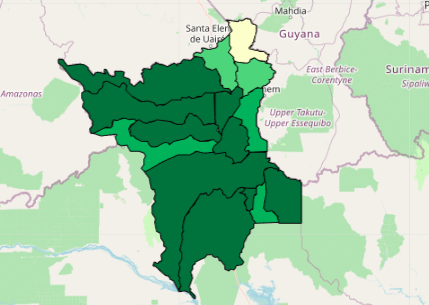

In [ ]:
ufCodes = pd.read_html('https://www.oobj.com.br/bc/article/quais-os-c%C3%B3digos-de-cada-uf-no-brasil-465.html',match='UF')[0]
ufCodes

In [ ]:
ufCodes[ ufCodes['UF'] == 'RR']['Código UF'].values[0]

In [101]:
def getUfCode(uf):
  return ufCodes[ ufCodes['UF'] == uf.upper()]['Código UF'].values[0]

In [105]:
def getGeoJson(uf):
  code = getUfCode(uf)
  geo_data_uf = requests.get(f'https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-{code}-mun.json').json()

  for index, mun in enumerate(geo_data_uf['features']) :
    geo_data_uf['features'][index]['properties']['name'] = mun['properties']['name'].capitalize()
  return geo_data_uf

In [123]:
def downloadUfData(uf):
  zipado = requests.get(f'https://cdn.tse.jus.br/estatistica/sead/eleicoes/eleicoes2022/buweb/bweb_2t_{uf.upper()}_311020221535.zip')
  open('zipe.zip','wb').write(zipado.content)

  file_name = "zipe.zip"

  with ZipFile(file_name, 'r') as zip:
    zip.printdir()
    zip.extractall()

In [ ]:
def getUfData(uf):
  downloadUfData(uf)
  with open(f'/content/bweb_2t_{uf.upper()}_311020221535.csv','rb') as f:
      munUfData = pd.read_csv(f,sep=";",encoding='latin-1')
  return munUfData

getUfData('rj')

In [ ]:
def generateUfMap(uf,cand):
  geo_data = getGeoJson(uf)
  usedDf = getUfData(uf)
  mapa = folium.Map(location=[2, -60], zoom_start=7)

  mapa.choropleth(geo_data=geo_data, data=usedDf,
                  columns=['state','% Votos'],
                  key_on='properties.name',  # Check your GeoJSON for the name!
                  fill_color='YlGn',
                  fill_opacity=1, 
                  line_opacity=1,legend_name=f'% de Votos para {cand}')
  return mapa

generateUfMap('ba','bolso')